In [1]:
from pygod.detector import CoLA
from pygod.metric import eval_roc_auc
import scipy.io
from torch_geometric.data import Data
import numpy as np
import pandas as pd
import networkx as nx
import torch
import os
from typing import Tuple, List, Literal
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import sys
import pickle
import os
from utils_unsup import set_random_seeds, eval_all
import matplotlib.pyplot as plt
import copy
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy_with_logits
from tqdm import tqdm
from utils import MMD_loss
from geomloss import SamplesLoss # Wasserstein Distance


path_model = './saved/models_unsup_ad_0826'
path_out = 'output/unsup_ad'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

def save_model(model,filename):
    with open(filename,'wb') as f:
        pickle.dump(model,f)

def read_model(filename):
    with open(filename,'rb') as f:
        return(pickle.load(f))
    
def clear():
    torch.cuda.empty_cache()

def load_data(
        dataname:Literal['YelpHotel','YelpRes','Amazon','YelpNYC'],
        if_split:bool=False,
        split:Tuple[float]=(0.6,0.2,0.2)
    ) -> Tuple[Data,np.ndarray]:
    dataset = scipy.io.loadmat(f'./dataset/{dataname}/{dataname}.mat')
    dataset['Network'].toarray()
    D = nx.DiGraph(dataset['Network'].toarray())
    edges = torch.tensor([[u for (u, v) in D.edges()],[v for (u,v) in D.edges()]], dtype=torch.int64)
    attr = torch.tensor(dataset['Attributes'].toarray(), dtype=torch.float)
    label = torch.tensor(dataset['Label'])
    data = Data(x=attr, edge_index=edges)

    if if_split:
        n = label.shape[0]
        train_mask, val_mask, test_mask = np.zeros(n).astype(bool), np.zeros(n).astype(bool), np.zeros(n).astype(bool)
        indexes = np.arange(n)
        np.random.shuffle(indexes)
        n_train, n_val = int(n*split[0]),int(n*split[1])
        train_mask[indexes[:n_train]] = True
        val_mask[indexes[n_train:(n_train+n_val)]] = True
        test_mask[indexes[(n_train+n_val):]] = True
        train_mask, val_mask, test_mask = torch.tensor(train_mask), torch.tensor(val_mask), torch.tensor(test_mask)
        data.train_mask, data.val_mask, data.test_mask = train_mask, val_mask, test_mask
    return data,label

data_src, label_src = load_data('YelpHotel',if_split=True)
data_tgt, label_tgt = load_data('YelpRes',if_split=False)

## Finetune with Wasserstein Distance

No enough GPU to complete MMD Distance calculation.

In [29]:
device = torch.device('cuda:0')
set_random_seeds(123,device='gpu')

model_cola = torch.load(os.path.join(path_model,'cola_src_model.pth'))
data_src,data_tgt = data_src.to(device),data_tgt.to(device)

encoder_s = model_cola.encoder
encoder_t = copy.deepcopy(encoder_s)
discriminator = model_cola.discriminator

for p in encoder_s.parameters():
    p.requires_grad = False
for p in discriminator.parameters():
    p.requires_grad = False


n_epoch = 80
t_optimizer = optim.Adam(params=encoder_t.parameters())
loss_w = SamplesLoss(loss="sinkhorn", p=2, blur=0.05)

loss_dist_list = []
loss_con_list = []

for epoch in tqdm(range(n_epoch)):
    emb_s = encoder_s(data_src.x, data_src.edge_index).to(device)
    emb_t = encoder_t(data_tgt.x, data_tgt.edge_index).to(device)
    logit_s = discriminator(data_src.x, emb_s).to(device)
    logit_t = discriminator(data_tgt.x, emb_t).to(device)

    perm_idx_s = torch.randperm(data_src.x.shape[0]).to(device)
    neg_logit_s = discriminator(data_src.x[perm_idx_s], emb_s)
    perm_idx_t = torch.randperm(data_tgt.x.shape[0]).to(device)
    neg_logit_t = discriminator(data_tgt.x[perm_idx_t], emb_t)

    logits_s = torch.cat([logit_s,neg_logit_s]).squeeze().to(device)
    logits_t = torch.cat([logit_t,neg_logit_t]).squeeze().to(device)
    con_label_s = torch.cat([torch.ones(data_src.x.shape[0]),torch.zeros(data_src.x.shape[0])]).squeeze().to(device)
    con_label_t = torch.cat([torch.ones(data_tgt.x.shape[0]),torch.zeros(data_tgt.x.shape[0])]).squeeze().to(device)

    loss_contrast = binary_cross_entropy_with_logits(logits_s,con_label_s)+\
        binary_cross_entropy_with_logits(logits_t,con_label_t)
    
    loss_dist = loss_w(emb_s,emb_t)
    # since loss_contrast is too small comparing to loss_dist and latter always wins
    # we increase the coefficient of loss_contrast to a large number
    loss = 50*loss_contrast + loss_dist
    
    # mmd = MMD_loss(kernel_type='rbf', kernel_mul=2.0, kernel_num=5)
    # loss_mmd = mmd(emb_s,emb_t)
    # loss = loss_contrast + loss_mmd

    loss_dist_list.append(loss_dist.detach().item())
    loss_con_list.append(loss_contrast.detach().item())
    
    t_optimizer.zero_grad()
    loss.backward()
    t_optimizer.step()

100%|██████████| 80/80 [00:07<00:00, 10.07it/s]


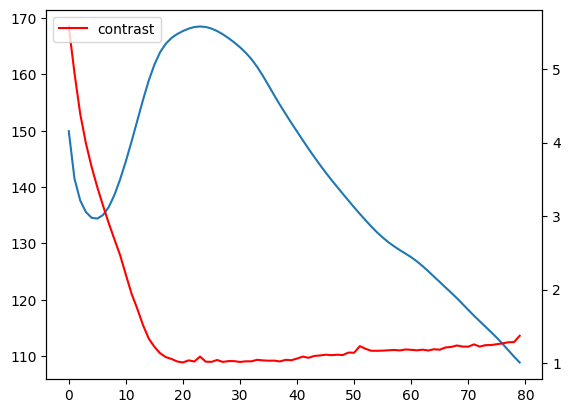

In [32]:
plt.plot(loss_dist_list,label='dist')
ax2 = plt.gca().twinx()
ax2.plot(loss_con_list,color='red',label='contrast')
plt.gca().legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [31]:
emb_t = encoder_t(data_tgt.x, data_tgt.edge_index).to(device)
logit_t = discriminator(data_tgt.x, emb_t).to(device)
from sklearn.metrics import roc_auc_score
roc_auc_score(label_tgt.detach().cpu().numpy().flatten(),logit_t.detach().cpu().numpy().flatten())

0.7042494750104997

```python
import torch
from geomloss import SamplesLoss

# 示例数据
x = torch.randn(100, 50)  # 样本1
y = torch.randn(100, 50)  # 样本2

# 使用 "sinkhorn" 模式计算 Wasserstein 距离
loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.05)
wasserstein_distance = loss(x, y)
print(f"Wasserstein Distance: {wasserstein_distance.item()}")
```